In [1]:
import numpy as np
import random
from scipy.linalg import expm, norm
from quairkit.qinfo.linalg import partial_trace
import scipy.io as sio
import scipy.sparse as sp
import matplotlib.pyplot as plt

In [2]:
def kron(*ops):
    M = np.array([[1]], dtype=complex)
    for A in ops:
        M = np.kron(M, A)
    return M

zero = np.array([1, 0], dtype=complex)
one  = np.array([0, 1], dtype=complex)

e00 = kron(zero, zero)
e01 = kron(zero, one)
e10 = kron(one,  zero)
e11 = kron(one,  one)

psi_plus  = (e01 + e10) / np.sqrt(2)   # eigenvalue +1
psi_minus = (e01 - e10) / np.sqrt(2)   # eigenvalue -1
phi_plus  = (e00 + e11) / np.sqrt(2)
phi_minus = (e00 - e11) / np.sqrt(2)

P_B = [
    np.outer(phi_plus,  phi_plus.conj()),
    np.outer(phi_minus, phi_minus.conj()),
    np.outer(psi_plus,  psi_plus.conj()),
    np.outer(psi_minus, psi_minus.conj())
]



In [ ]:
def D_B(rho):
    out = np.zeros_like(rho, dtype=complex)
    for P in P_B:
        out += P @ rho @ P
    return out

In [4]:
def program_state_for_exp_it_adS(t):
    """
    |ψ(t)> = ( e^{-it} |ψ_-> + e^{it} |ψ_+> ) / √2
    """
    psi = (np.exp(-1j * t) * psi_minus + np.exp(1j * t) * psi_plus) / np.sqrt(2)
    return np.outer(psi, psi.conj())    # 4×4

In [ ]:
def apply_choi(J_BA, rho_A, dB, dA):
    """
    J_BA : Choi on B⊗A, dimension (dB*dA , dB*dA)
    rho_A: rho out (dA , dA)
    """
    KR = np.kron(np.eye(dB, dtype=complex), rho_A.T)   # I_B ⊗ ρ^T
    M  = J_BA @ KR
    
    rho_out = partial_trace(M, trace_idx=1, system_dim=[dB, dA])
    return rho_out

def apply_super_channel(J, prog, rho_A, dB, dP, dA):
    T_prog = kron(np.eye(dB, dtype=complex), prog.T, np.eye(dA, dtype=complex))  # 64×64

    M = J @ T_prog

    
    J_U = partial_trace(M, trace_idx=1, system_dim=[dB, dP, dA])   # 16×16

    
    rho_out = apply_choi(J_U, rho_A, dB=dB, dA=dA)
    return rho_out




In [ ]:
def quasi_sampling_state_estimate(
        J_O1, J_O2, eta1, eta2,
        rho_A, prog,
        dB, dP, dA,
        num_samples,
        seed=None):

    if seed is not None:
        random.seed(seed)

    
    O1_rho = apply_super_channel(J_O1, prog, rho_A, dB, dP, dA)
    O2_rho = apply_super_channel(J_O2, prog, rho_A, dB, dP, dA)

    q1    = eta1 / (eta1 + eta2)
    scale = eta1 + eta2

    rho_acc = np.zeros_like(rho_A, dtype=complex)

    for _ in range(num_samples):
        if random.random() < q1:
            rho_acc +=  scale * O1_rho
        else:
            rho_acc += -scale * O2_rho

    return rho_acc / num_samples

In [ ]:
def evolve_Lindblad(rho0, psi0,
                    T, steps, lam, cycles,
                    J_O1, J_O2, eta1, eta2,
                    dB, dP, dA, hptp_num_samples):

    times  = np.linspace(0, T, steps)
    values = []
    P0 = np.outer(psi0, psi0.conj())  # |ψ0><ψ0|

    for t in times:
        a = np.exp(-lam * t)  # ã(t)
        val_acc = 0.0

        for _ in range(cycles):
            rho_sys = rho0.copy()

            if random.random() < a:
                
                prog = program_state_for_exp_it_adS(t)

                rho_sys = quasi_sampling_state_estimate(
                    J_O1, J_O2, eta1, eta2,
                    rho_sys, prog,
                    dB, dP, dA,
                    hptp_num_samples
                )
            else:
                
                rho_sys = D_B(rho_sys)

            fid = np.real(np.trace(rho_sys @ P0))
            val_acc += fid

        values.append(val_acc / cycles)

    return times, np.array(values)

In [8]:
def to_numpy(M):
    return M.toarray() if sp.issparse(M) else np.array(M, dtype=complex)

J1_mat = sio.loadmat(r'C:\Users\ZL137\Desktop\Programming\J1.mat')
J2_mat = sio.loadmat(r'C:\Users\ZL137\Desktop\Programming\J2.mat')
J1 = to_numpy(J1_mat['J1'])
J2 = to_numpy(J2_mat['J2'])
J_O1, J_O2 = J1, J2




In [9]:
psi0 = e01              # |01>
rho0 = np.outer(psi0, psi0.conj())

times, vals = evolve_Lindblad(
    rho0, psi0,
    T=10, steps=101, lam=0.5, cycles=1000,
    J_O1=J_O1, J_O2=J_O2, eta1=1.0, eta2=1.0,
    dB=4, dP=4, dA=4,
    hptp_num_samples=200
)

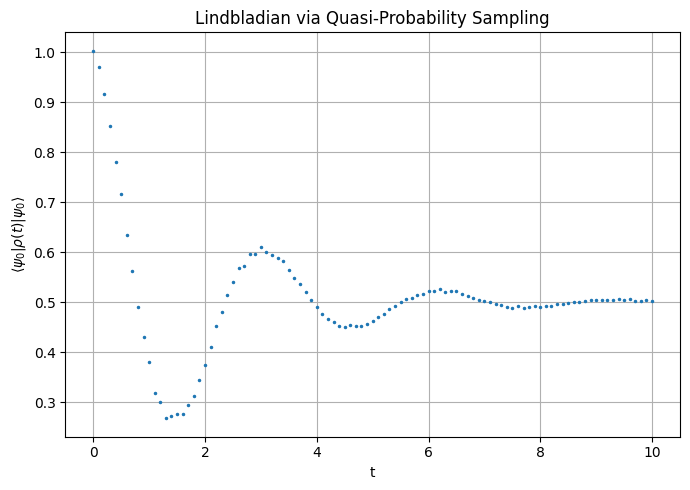

In [10]:
plt.figure(figsize=(7,5))
plt.plot(times, vals, '.', markersize=3)
plt.xlabel("t")
plt.ylabel(r"$\langle\psi_0|\rho(t)|\psi_0\rangle$")
plt.title("Lindbladian via Quasi-Probability Sampling")
plt.grid(True)
plt.tight_layout()
plt.show()

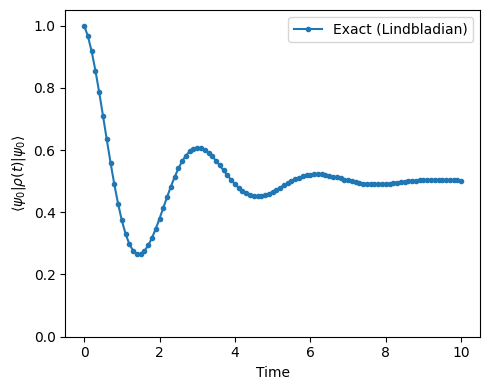

In [ ]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt



def kron(*ops):
    """Kronecker product of many operators."""
    out = np.array([[1.0+0j]])
    for op in ops:
        out = np.kron(out, op)
    return out

def vec(rho):
    """Column-stacking vectorization of a matrix."""
    return rho.reshape(-1, order="F")

def unvec(v, dim):
    """Inverse of vec: dim x dim matrix from vector."""
    return v.reshape((dim, dim), order="F")



# computational basis |0>, |1>
zero = np.array([1, 0], dtype=complex)
one  = np.array([0, 1], dtype=complex)

# 2-qubit basis |00>,|01>,|10>,|11>
e00 = kron(zero, zero)
e01 = kron(zero, one)
e10 = kron(one,  zero)
e11 = kron(one,  one)

dim = 4
I4 = np.eye(dim, dtype=complex)

# swap operator S: S |ij> = |ji>
S = np.zeros((dim, dim), dtype=complex)
basis = [e00, e01, e10, e11]
for i, ket in enumerate(basis):
    if i == 0:
        j_idx = 0   # |00> -> |00>
    elif i == 1:
        j_idx = 2   # |01> -> |10>
    elif i == 2:
        j_idx = 1   # |10> -> |01>
    else:
        j_idx = 3   # |11> -> |11>
    S[j_idx, i] = 1.0

# Bell states and projectors
phi_plus  = (e00 + e11) / np.sqrt(2)
phi_minus = (e00 - e11) / np.sqrt(2)
psi_plus  = (e01 + e10) / np.sqrt(2)
psi_minus = (e01 - e10) / np.sqrt(2)

bells = [phi_plus, phi_minus, psi_plus, psi_minus]
P_list = [np.outer(b, b.conj()) for b in bells]



lam = 0.5  # dephasing rate λ

# Hamiltonian part: i [S, ρ]
L_ham = 1j * (np.kron(I4, S) - np.kron(S.T, I4))

# Dephasing part: λ( D_B(ρ) - ρ )
D_mat = np.zeros((dim * dim, dim * dim), dtype=complex)
for P in P_list:
    D_mat += np.kron(P.T, P)

L_deph = lam * (D_mat - np.eye(dim * dim, dtype=complex))

# Total Liouvillian
L = L_ham + L_deph



psi0 = e01.reshape(-1)  # ensure 1D vector of length 4
rho0 = np.outer(psi0, psi0.conj())
rho0_vec = vec(rho0)

# projector onto |psi0>
P0 = np.outer(psi0, psi0.conj())



times = np.linspace(0.0, 10, 101)
fidelity = []

for t in times:
    # E_t = exp(t L)
    E_t = expm(t * L)
    rho_t_vec = E_t @ rho0_vec
    rho_t = unvec(rho_t_vec, dim)

    # overlap <psi0| ρ(t) |psi0> = Tr[rho_t P0]
    fid = np.real(np.trace(rho_t @ P0))
    fidelity.append(fid)

# ---------- plot ----------

plt.figure(figsize=(5, 4))
plt.plot(times, fidelity, marker=".", linestyle="-", label="Exact (Lindbladian)")
plt.xlabel("Time")
plt.ylabel(r"$\langle \psi_0 | \rho(t) | \psi_0 \rangle$")
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()


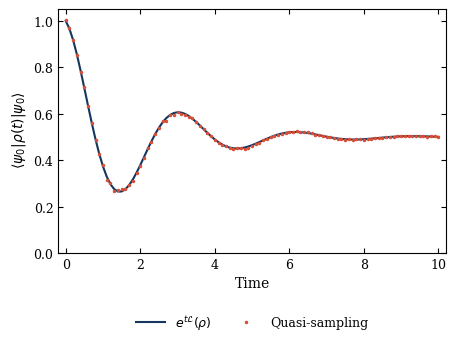

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt


mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "axes.linewidth": 0.8,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
})


color_line   = '#14365F' 
color_points = '#D64F38' 

fig, ax = plt.subplots(figsize=(5.0, 4.0))


ax.plot(
    times,
    fidelity,
    color=color_line,
    lw=1.5,
    label=r'$e^{t \mathcal{L}}(\rho)$'
)


ax.plot(
    times,
    vals,
    linestyle='none',
    marker='.',
    markersize=3,
    color=color_points,
    label=r'Quasi-sampling'
)

ax.set_xlabel(r'Time')
ax.set_ylabel(r' $\langle \psi_0 | \rho(t) | \psi_0 \rangle$')

ax.set_ylim(0.0, 1.05)
ax.margins(x=0.02)


ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.20),
    frameon=False,
    ncol=2,
    handlelength=2.3,
    columnspacing=1.6,
)

ax.tick_params(direction='in', top=True, right=True)

fig.subplots_adjust(bottom=0.27)
plt.show()

plt.tight_layout()
plt.savefig("non_unitary_evolution.pdf", bbox_inches="tight")